# Load Data and Preprocess

In [20]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Set seed

SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Computer Vision/Assignment1'

In [ ]:
from PIL import Image
import os

image_path = '/content/drive/MyDrive/Computer Vision/Assignment1/train/adho mukha svanasana/3. downward-facing-dog-pose-567x567.png'
image = Image.open(image_path)

# Get the dimensions of the image
width, height = image.size
print(f"Image dimensions: {width}x{height}")

Image dimensions: 567x567


In [ ]:
# Locate files in folder
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'
val_dir = f'{data_dir}/val'

# Function to load and label
def load_and_preprocess_data(directory, image_size=(128,128), batch_size=32, color_mode='rgb'):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='int',
        color_mode=color_mode
    )
    return dataset

# Load datasets
train = load_and_preprocess_data(train_dir)
test = load_and_preprocess_data(test_dir)
val = load_and_preprocess_data(val_dir)

Found 4176 files belonging to 107 classes.
Found 687 files belonging to 107 classes.
Found 1157 files belonging to 107 classes.


In [ ]:
# Normalize images to [0, 1] by dividing by 255
def normalize_images(dataset):
    return dataset.map(lambda x, y: (x / 255.0, y))

train = normalize_images(train)
test = normalize_images(test)
val = normalize_images(val)

def augment_data(dataset):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1)
    ])
    return dataset.map(lambda x, y: (data_augmentation(x), y))

train = augment_data(train)  # Augment only training data

In [ ]:
# Train Images

x_train = []
y_train = []

for images, labels in train:
    x_train.append(images)
    y_train.append(labels)

x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

# Test Images

x_test = []
y_test = []

for images, labels in test:
    x_test.append(images)
    y_test.append(labels)

x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Val Images

x_val = []
y_val = []

for images, labels in val:
    x_val.append(images)
    y_val.append(labels)

x_val = tf.concat(x_val, axis=0)
y_val = tf.concat(y_val, axis=0)

In [ ]:
# Deal with imbalanced classes

from sklearn.utils import class_weight

# Ensure y_train is a NumPy array
y_train_np = y_train.numpy() if tf.is_tensor(y_train) else y_train

# Compute balanced class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

# Convert to dict
class_weights = dict(enumerate(class_weights))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Final Model from Assignment1

In [ ]:
# Define the model
def create_advanced_CNN(input_shape, num_classes):
    model = Sequential()

    # Conv. layer 1 with BN
    model.add(Conv2D(32, (3, 3), activation=None, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv. layer 2 with BN
    model.add(Conv2D(32, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # Conv. layer 3
    model.add(Conv2D(64, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv. layer 4
    model.add(Conv2D(64, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # Conv. layer 5
    model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv. layer 6
    model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # Conv. layer 7
    model.add(Conv2D(256, (3, 3), activation=None, padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv. layer 8
    model.add(Conv2D(256, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # Conv. layer 9
    model.add(Conv2D(512, (3, 3), activation=None, padding='same', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Conv. layer 10
    model.add(Conv2D(512, (3, 3), activation=None, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(Dropout(0.3))

    # Conv. layer 11
    model.add(Conv2D(1024, (3, 3), activation=None, kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(Dropout(0.2))

    # Flatten from 3D to 1D
    model.add(Flatten())

    # Dense layer
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
# Create the model
model = create_advanced_CNN(input_shape=(128,128,3), num_classes=107)

# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=50000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with Adam
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',  # for multi-class
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 256)    │       295,16

 Total params: 10,023,563 (38.24 MB)

 Trainable params: 10,017,547 (38.21 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [ ]:
# Train the model

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=15,
                               restore_best_weights=True)

history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          class_weight=class_weights,
          callbacks=[early_stopping]
          )

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.0098 - loss: 21.0026 - val_accuracy: 0.0102 - val_loss: 13.7485
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.0216 - loss: 11.5442 - val_accuracy: 0.0087 - val_loss: 8.8080
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.0708 - loss: 7.2602 - val_accuracy: 0.0116 - val_loss: 7.1296
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1090 - loss: 5.9919 - val_accuracy: 0.0422 - val_loss: 6.2003
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1526 - loss: 5.3841 - val_accuracy: 0.1543 - val_loss: 5.3323
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1916 - loss: 4.9171 - val_accuracy: 0.2038 - val_loss: 4.8582
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2495 - loss: 4.5605 - val_accuracy: 0.2285 - val_loss: 4.8218
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2833 - loss: 4.2314 - val_accurac

In [ ]:
# Save model for use later

model.save("CNN_yoga_model.keras")

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Restored model accuracy: {acc:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.4860 - loss: 2.6404
Restored model accuracy: 0.4949


# Perform CNN transfer learning to classify the Yoga dataset from Assignment 1.

Data prep: Changing image size to 224x224 for EfficientNet expected shape.

In [ ]:
# Load and label
def load_and_preprocess_data(directory, image_size=(224, 224), batch_size=32, color_mode='rgb'):
      dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='int',
        color_mode=color_mode
    )
      return dataset

# Load datasets
train = load_and_preprocess_data(train_dir)
test = load_and_preprocess_data(test_dir)
val = load_and_preprocess_data(val_dir)

Found 4176 files belonging to 107 classes.
Found 687 files belonging to 107 classes.
Found 1157 files belonging to 107 classes.


In [ ]:
# Augment data
def augment_data(dataset):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1)
    ])
    return dataset.map(lambda x, y: (data_augmentation(x), y))

train = augment_data(train)  # Augment only training data

In [ ]:
# Train Images

x_train = []
y_train = []

for images, labels in train:
    x_train.append(images)
    y_train.append(labels)

x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

# Test Images

x_test = []
y_test = []

for images, labels in test:
    x_test.append(images)
    y_test.append(labels)

x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Val Images

x_val = []
y_val = []

for images, labels in val:
    x_val.append(images)
    y_val.append(labels)

x_val = tf.concat(x_val, axis=0)
y_val = tf.concat(y_val, axis=0)

In [ ]:
# Preprocess for EfficientNet to normalize input pixels to [-1,1] instead of [0,255]
from tensorflow.keras.applications.efficientnet import preprocess_input

# Preprocess images
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [ ]:
# Train Test Split

# Combine the train and test and val
all_images = np.concatenate((x_train, x_test, x_val), axis=0)
all_labels = np.concatenate((y_train, y_test, y_val), axis=0)

# 80/20 split
x_train, x_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42)

# Output
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (4816, 224, 224, 3)
4816 train samples
1204 test samples


In [ ]:
# Deal with imbalanced classes

from sklearn.utils import class_weight

# Ensure y_train is a NumPy array
y_train_np = y_train.numpy() if tf.is_tensor(y_train) else y_train

# Compute balanced class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

# Convert to dict
class_weights = dict(enumerate(class_weights))

EfficientNet load & train

In [ ]:
# Load EfficientNet
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
len(base_model.layers)

238

Freeze most of the layers, unfreeze and train the last few layers on the dataset. Unfreeze less than 50% (less than the last 119).

In [ ]:
# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers (last 30%)
for layer in base_model.layers[-70:]:
    layer.trainable = True

In [ ]:
# Standard for EfficientNet is GlobalAveragePooling2D instead of Flatten() to preserve spatial meaning better
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
# Add new head
model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(107, activation='softmax')
])

In [ ]:
# Define learning rate decay

from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

In [ ]:
# Compile model
model_transfer.compile(optimizer=Adam(learning_rate=lr_schedule),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [ ]:
# Train and test model
history_transfer = model_transfer.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_test, y_test),
    class_weight=class_weights
)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 88s 591ms/step - accuracy: 0.0455 - loss: 4.4519 - val_accuracy: 0.2774 - val_loss: 2.6442
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.3097 - loss: 2.6144 - val_accuracy: 0.4967 - val_loss: 1.8009
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5085 - loss: 1.5888 - val_accuracy: 0.5872 - val_loss: 1.4580
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6710 - loss: 1.0700 - val_accuracy: 0.6196 - val_loss: 1.4383
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7744 - loss: 0.7191 - val_accuracy: 0.6312 - val_loss: 1.3997
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8197 - loss: 0.5351 - val_accuracy: 0.6520 - val_loss: 1.6461
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8638 - loss: 0.4010 - val_accuracy: 0.6453 - val_loss: 1.5201
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8850 - loss: 0.3517 - val_accuracy: 0.6927 -

In [ ]:
# Save model for use later

model_transfer.save("transfer_yoga_model.keras")

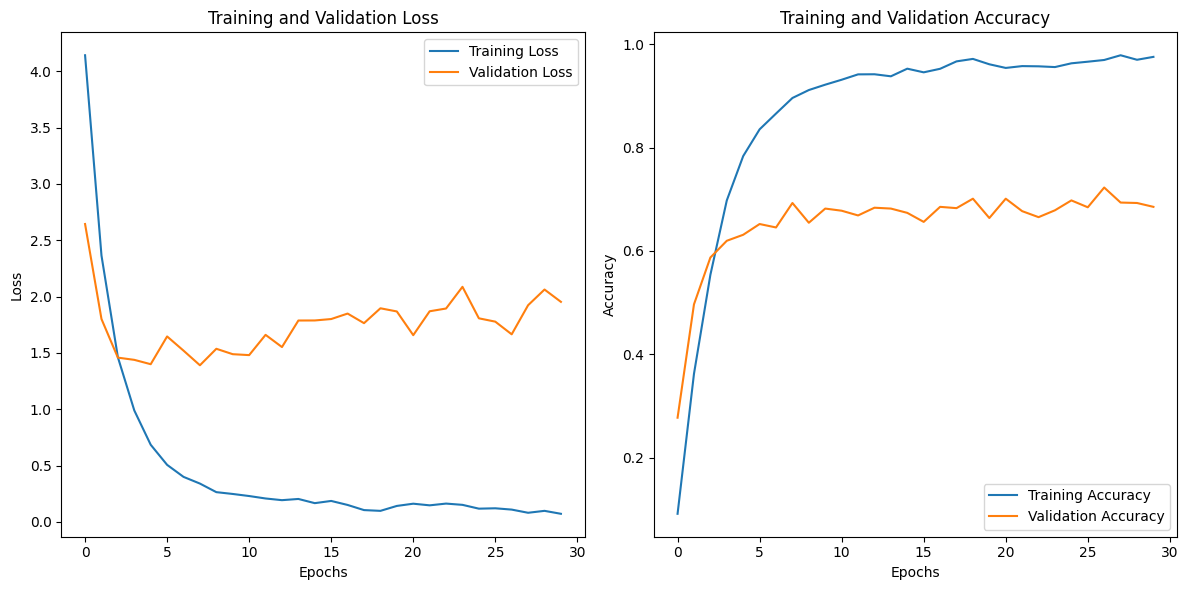

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

Does transfer learning benefit this problem? Explain your observations.

Yes, EfficientNet transfer learning benefitted this yoga poses problem. I had to readjust some preprocessing to fit EfficientNet, such as image size 224x224 instead of 128x128 that I used for CNN, and the normalization of [-1,1] instead of [0,255]. After these adjustments and adding a learning rate scheduled decay, the fine-tuned EfficientNet achieved a validation accuracy of around 68% (around 20% higher than my CNN). The pre-trained EfficientNet was able to do the initial learning much quicker, as evidenced by the graphs above. The only downside is that is still overfit the training data set, even with dropouts ranging from 0.3 to 0.5 in my head that I added on. More regularization or data augmentation could help in future work.


In [ ]:
# Check basic performance
loss, acc = model_transfer.evaluate(x_test, y_test)
print(f"Restored model accuracy: {acc:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.6859 - loss: 1.9858
Restored model accuracy: 0.6852


In [ ]:
class_names = ['adho mukha svanasana', 'adho mukha vriksasana', 'agnistambhasana',
               'ananda balasana', 'anantasana', 'anjaneyasana', 'ardha bhekasana',
               'ardha chandrasana', 'ardha matsyendrasana', 'ardha pincha mayurasana',
               'ardha uttanasana', 'ashtanga namaskara', 'astavakrasana', 'baddha konasana',
               'bakasana', 'balasana', 'bhairavasana', 'bharadvajasana i', 'bhekasana',
               'bhujangasana', 'bhujapidasana', 'bitilasana', 'camatkarasana', 'chakravakasana',
               'chaturanga dandasana', 'dandasana', 'dhanurasana', 'durvasasana', 'dwi pada viparita dandasana',
               'eka pada koundinyanasana i', 'eka pada koundinyanasana ii', 'eka pada rajakapotasana',
               'eka pada rajakapotasana ii', 'ganda bherundasana', 'garbha pindasana', 'garudasana',
               'gomukhasana', 'halasana', 'hanumanasana', 'janu sirsasana', 'kapotasana', 'krounchasana', 'kurmasana', 'lolasana',
               'makara adho mukha svanasana', 'makarasana', 'malasana', 'marichyasana i', 'marichyasana iii',
               'marjaryasana', 'matsyasana', 'mayurasana', 'natarajasana', 'padangusthasana', 'padmasana', 'parighasana',
               'paripurna navasana', 'parivrtta janu sirsasana', 'parivrtta parsvakonasana', 'parivrtta trikonasana',
               'parsva bakasana', 'parsvottanasana', 'pasasana', 'paschimottanasana', 'phalakasana', 'pincha mayurasana',
               'prasarita padottanasana', 'purvottanasana', 'salabhasana', 'salamba bhujangasana', 'salamba sarvangasana',
               'salamba sirsasana', 'savasana', 'setu bandha sarvangasana', 'simhasana', 'sukhasana', 'supta baddha konasana',
               'supta matsyendrasana', 'supta padangusthasana', 'supta virasana', 'tadasana', 'tittibhasana', 'tolasana', 'tulasana',
               'upavistha konasana', 'urdhva dhanurasana', 'urdhva hastasana', 'urdhva mukha svanasana', 'urdhva prasarita eka padasana',
               'ustrasana', 'utkatasana', 'uttana shishosana', 'uttanasana', 'utthita ashwa sanchalanasana', 'utthita hasta padangustasana',
               'utthita parsvakonasana', 'utthita trikonasana', 'vajrasana', 'vasisthasana', 'viparita karani', 'virabhadrasana i', 'virabhadrasana ii',
               'virabhadrasana iii', 'virasana', 'vriksasana', 'vrischikasana', 'yoganidrasana']

In [ ]:
image_path = '/content/drive/MyDrive/Computer Vision/Assignment1/train/anantasana/7-0.png'

In [ ]:
# Example test
from PIL import Image
import numpy as np

# Load one image
img = Image.open(image_path).convert('RGB').resize((224,224))
img = np.array(img).astype('float32')
#mg = (img / 127.5) - 1.0
img = np.expand_dims(img, axis=0)

# Predict
pred = model_transfer.predict(img)
predicted_index = np.argmax(pred)
confidence = np.max(pred)

# Now print the result
print(f"Predicted Class: {predicted_index}")
print(f"Pose Name: {class_names[predicted_index]}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class: 4
Pose Name: anantasana
Confidence: 1.00


In [ ]:
for i in range(10):
    img = x_test[i]   # No .numpy() needed
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    pred = model_transfer.predict(img)
    print(f"True label: {y_test[i]}, Predicted: {np.argmax(pred)}, Confidence: {np.max(pred):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
True label: 44, Predicted: 64, Confidence: 0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
True label: 104, Predicted: 104, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
True label: 52, Predicted: 52, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
True label: 89, Predicted: 89, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True label: 1, Predicted: 1, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True label: 35, Predicted: 35, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
True label: 19, Predicted: 45, Confidence: 0.40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True label: 88, Predicted: 88, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True label: 78, Predicted: 78, Confidence: 0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True label: 43, Predicted: 43, Confidence: 1.00


# Web Application

Load and Quantize Models

In [ ]:
# Quantize CNN model
cnn_model = tf.keras.models.load_model("CNN_yoga_model.keras")
converter_cnn = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter_cnn.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_cnn = converter_cnn.convert()

with open('CNN_yoga_model_quantized.tflite', 'wb') as f:
    f.write(tflite_model_cnn)

Saved artifact at '/tmp/tmpl6czk4n_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 107), dtype=tf.float32, name=None)
Captures:
  140367255920784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255922704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255918480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255921744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255918672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255917904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255924048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255923856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255923280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140367255913104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14036725591

In [ ]:
# Load the good transfer model
transfer_model = tf.keras.models.load_model("transfer_yoga_model.keras")

# Quantize transfer model
converter_transfer = tf.lite.TFLiteConverter.from_keras_model(transfer_model)
converter_transfer.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_transfer = converter_transfer.convert()

# Save it
with open('transfer_yoga_model_quantized.tflite', 'wb') as f:
    f.write(tflite_model_transfer)

Saved artifact at '/tmp/tmpwkx4_7h8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 107), dtype=tf.float32, name=None)
Captures:
  140366128023312: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140366128023120: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140366418476496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366132282384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366132281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366418475920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366132283152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366132282960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366132284496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140366132285456: TensorSpec(shape=(), dtype=tf.resource, name=N

In [ ]:
!ls -lh *.tflite

-rw-r--r-- 1 root root 9.7M May  2 21:54 CNN_yoga_model_quantized.tflite
-rw-r--r-- 1 root root 5.2M May  2 21:54 transfer_yoga_model_quantized.tflite


In [ ]:
# Copy CNN model
!cp CNN_yoga_model_quantized.tflite /content/drive/MyDrive/HiraPersonalCV/CNN_yoga_model_quantized.tflite

In [ ]:
# Copy Transfer Learning model
!cp transfer_yoga_model_quantized.tflite /content/drive/MyDrive/HiraPersonalCV/transfer_yoga_model_quantized.tflite

Remainder of Web App is in Yoga_WebApp_HiraStanley.py file.

# Feature Clustering

Remove the top layers from your best CNN and extract feature from your images.

In [ ]:
# Reloading images again since I augmented them differently for EfficientNet

# Train Images

x_train = []
y_train = []

for images, labels in train:
    x_train.append(images)
    y_train.append(labels)

x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

# Test Images

x_test = []
y_test = []

for images, labels in test:
    x_test.append(images)
    y_test.append(labels)

x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Val Images

x_val = []
y_val = []

for images, labels in val:
    x_val.append(images)
    y_val.append(labels)

x_val = tf.concat(x_val, axis=0)
y_val = tf.concat(y_val, axis=0)

In [ ]:
# Create a new model feature_extractor that removes the last 3 layers

# Load CNN model
cnn_model = tf.keras.models.load_model("CNN_yoga_model.keras")

# Rebuild the model input manually and match original input size
from tensorflow.keras import Model, Input
input_tensor = Input(shape=(128, 128, 3))

# Pass through layers one-by-one manually
x = input_tensor
for layer in cnn_model.layers[:-3]:  # Remove the last 3 layers (adjust based on your model)
    x = layer(x)

# Create the feature extractor
feature_extractor = Model(inputs=input_tensor, outputs=x)

# Check output shape
print("Feature extractor output shape:", feature_extractor.output_shape)

Feature extractor output shape: (None, 1024)


Flatten the feature vectors obtained in the previous step for further processing.

In [ ]:
# Extract features - pass all x_test images through model up to the feature extraction point
features = feature_extractor.predict(x_test, batch_size=32, verbose=1)

# Flatten features into 1d vector to apply clustering later
flattened_features = features.reshape(features.shape[0], -1)

print(flattened_features.shape)  # num_images in x_test, num_features per image

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
(687, 1024)


Apply clustering algorithms K-means or DBSCAN on the flattened feature vectors to group similar poses.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=5)
cluster_labels_d = dbscan.fit_predict(flattened_features)

unique_clusters, counts = np.unique(cluster_labels_d, return_counts=True)
print(dict(zip(unique_clusters, counts)))
# Everything got classified as noise - no clusters found

{np.int64(-1): np.int64(687)}


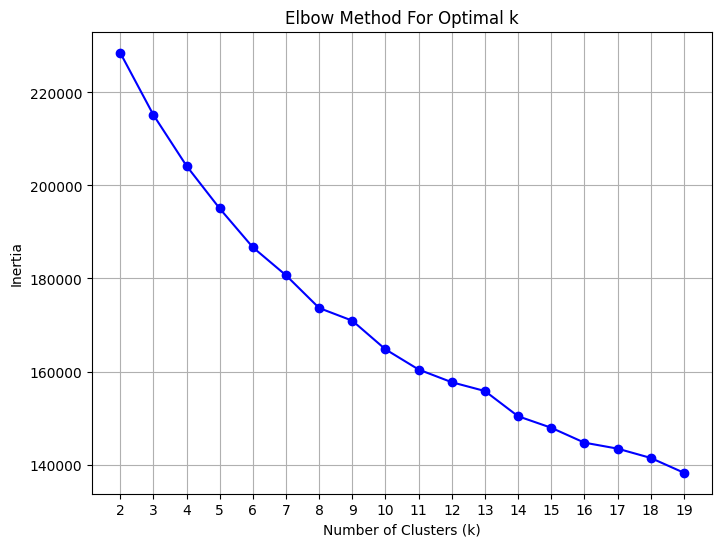

In [ ]:
# K-Means
from sklearn.cluster import KMeans

inertia_list = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(flattened_features)
    inertia_list.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_list, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_k = kmeans.fit_predict(flattened_features)

unique_clusters, counts = np.unique(cluster_labels_k, return_counts=True)
print("Cluster Sizes:")
for cluster_id, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster_id}: {count} samples")

Cluster Sizes:
Cluster 0: 64 samples
Cluster 1: 95 samples
Cluster 2: 83 samples
Cluster 3: 77 samples
Cluster 4: 59 samples
Cluster 5: 67 samples
Cluster 6: 74 samples
Cluster 7: 70 samples
Cluster 8: 47 samples
Cluster 9: 51 samples


Evaluate the performance on your unsupervised approach using metrics like Silhouette Score. How many clusters do you see and how do they map to the different types of poses?

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(flattened_features, cluster_labels_k)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.1032


Silhouette score is relatively weak at 0.10, but with 107 yoga poses it would be hard to achieve perfect clustering. Elbow method did not have a blatant elbow to determine the k, but I tested out several and k=10 gave me clusters of about equal size.

In [ ]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame({
    'True Pose': y_test,
    'Cluster': cluster_labels_k
})

pivot_table = pd.pivot_table(
    df,
    index='Cluster',
    columns='True Pose',
    aggfunc='size',
    fill_value=0
)

pivot_table

True Pose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,1,3,1,4,0,0,0,0,1,2,1,0,0,0,0,2,1,0,0,0,0,0,1,0,0,5,2,0,0,0,0,5,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,1,5,5
1,0,0,0,5,5,0,4,0,0,0,0,0,0,0,0,2,2,0,0,8,0,10,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,5,1,1,0,0,0,0,0,2,1,1,1,1,0,0,0,0,1,0,2,0,0,0,0,0,0,3,0,0,0,0,4,3,1,0,1,0,1,0,1,1,6,0,0,0,0,0,1,0,0,5,0,0,0,5,0,1,0,0,0,0,1,4,0,0,0,0,0,0,0
2,1,0,1,1,0,7,0,1,1,0,2,0,0,2,0,2,0,0,0,0,0,0,1,2,0,5,0,0,0,0,0,3,1,0,0,0,0,0,3,1,1,0,0,0,1,0,0,1,3,4,0,0,0,0,4,4,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,2,1,0,0,0,9,1,0,1,1,0,0,1,1,0,1,0,0,6,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,1,1,6,0,9,0,0,0,1,0,4,0,0,0,6,0,0,1,0,5,5,0,0,0,0,1,0,0,0,1,0,0,2,4,0,1,1,1,0,0,0,5,0,2,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,4,6,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,6,7,0,6,0,6,6,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,4,1,1,0,4,0,0,0,0,3,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,3,3,0,1,0,0,7,0,0,0,0,0,0,3,0,0,1,0,0,1,1,0,0,0,1,1,0,0,5,2,0,0,6,3,0,6,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,3,0,0,0,0,0,8,0,0,0,0,3,0,0,0,7,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,8,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,3,4,0,0,0,0,2,0,6,4,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,3,0,0,0
7,6,1,0,0,0,0,0,3,1,6,3,0,0,0,0,0,0,0,0,0,0,0,6,0,1,0,0,0,5,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,5,0,1,7,0,0,0,1,0,5,0,0,0,1,1,0,0,0,0,0,0,5,0,0,0,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,6,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,4,0,0,0,2,0,0,0,7,0,0,0,0,0,0,0,0,0,6,0,0


# Pose Estimation Model

Use any Pose Estimation model from this list and extract poses from the Yoga dataset.

In [12]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [13]:
from ultralytics import YOLO

# Load a model
model_yolo = YOLO("yolo11n-pose.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.97M/5.97M [00:00<00:00, 68.8MB/s]


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Explore the possibility of using extracted pose estimation data to classify yoga poses.

Processing: /content/drive/MyDrive/Computer Vision/Assignment1/test/adho mukha svanasana/13. downward-facing-dog-800x490.png

image 1/1 /content/drive/MyDrive/Computer Vision/Assignment1/test/adho mukha svanasana/13. downward-facing-dog-800x490.png: 416x640 1 person, 97.9ms
Speed: 3.6ms preprocess, 97.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


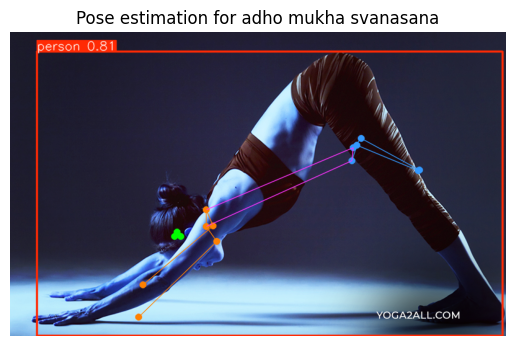

Processing: /content/drive/MyDrive/Computer Vision/Assignment1/test/bakasana/4-0.png

image 1/1 /content/drive/MyDrive/Computer Vision/Assignment1/test/bakasana/4-0.png: 640x608 1 person, 147.1ms
Speed: 4.0ms preprocess, 147.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


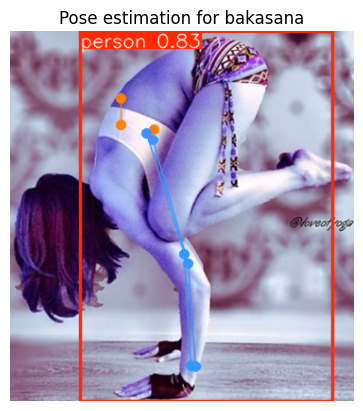

Processing: /content/drive/MyDrive/Computer Vision/Assignment1/test/chakravakasana/2-1.png

image 1/1 /content/drive/MyDrive/Computer Vision/Assignment1/test/chakravakasana/2-1.png: 416x640 2 persons, 94.2ms
Speed: 2.6ms preprocess, 94.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


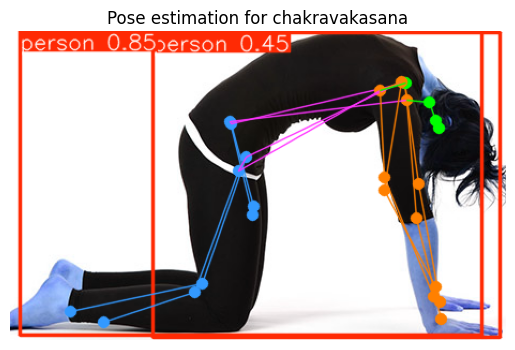

Processing: /content/drive/MyDrive/Computer Vision/Assignment1/test/parsvottanasana/3-0.png

image 1/1 /content/drive/MyDrive/Computer Vision/Assignment1/test/parsvottanasana/3-0.png: 640x608 1 person, 114.6ms
Speed: 2.7ms preprocess, 114.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


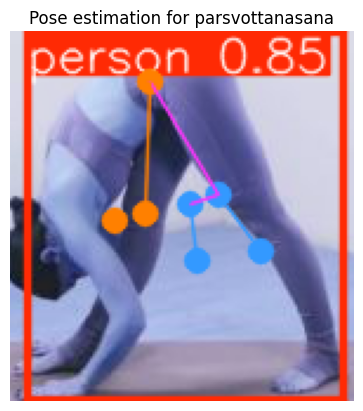

Processing: /content/drive/MyDrive/Computer Vision/Assignment1/test/sukhasana/71-0.png

image 1/1 /content/drive/MyDrive/Computer Vision/Assignment1/test/sukhasana/71-0.png: 640x576 1 person, 128.0ms
Speed: 2.8ms preprocess, 128.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


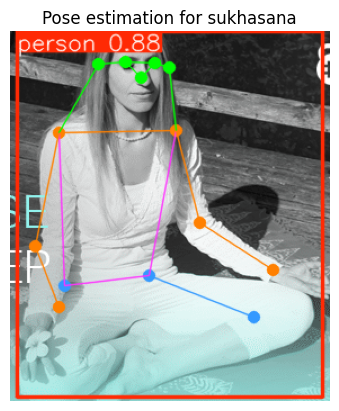

In [21]:
data_roots = ['/content/drive/MyDrive/Computer Vision/Assignment1/test/adho mukha svanasana',
              '/content/drive/MyDrive/Computer Vision/Assignment1/test/bakasana',
              '/content/drive/MyDrive/Computer Vision/Assignment1/test/chakravakasana',
              '/content/drive/MyDrive/Computer Vision/Assignment1/test/parsvottanasana',
              '/content/drive/MyDrive/Computer Vision/Assignment1/test/sukhasana']

# Loop through each folder
for folder in data_roots:
    # Get the first image in the folder
    first_image = next(
        (os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))),
        None
    )

    if first_image:
        print(f"Processing: {first_image}")
        results = model_yolo(first_image)

        # Plot the results
        plt.imshow(results[0].plot())
        plt.axis("off")  # Hide axes for clarity
        plt.title(f"Pose estimation for {os.path.basename(folder)}")
        plt.show()
    else:
        print(f"No images found in {folder}. Skipping.")

In [22]:
# Keypoints for joint detection

# Get keypoints data
keypoints = results[0].keypoints

# Confidence scores for each detected keypoint
print(keypoints.conf)

tensor([[0.9971, 0.9898, 0.9845, 0.6727, 0.8102, 0.9995, 0.9877, 0.9984, 0.8875, 0.9892, 0.8446, 0.9976, 0.9837, 0.7696, 0.4030, 0.0995, 0.0318]])


What would be your final approach for yoga pose classification and why?

I think the YOLO 11 pose model is a good starting point in yoga pose classification because it can detect with high confidence the keypoints/joints from the images. We could then convert the keypoints into feature vectors, so a future model can work on this less complex data. Then any classifier model such as CNN or Random Forest or XGBoost could be used to label the poses, which we could then evaluate with accuracy scores.

This would increase speed and reduce complexity, since the model is identifying joint coordinates instead of the appearance of the person in the photo (color vs. grayscale, clothes, backgrounds, etc.). It would also help identify which joint coordinates matter for which pose.

# Download this file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

# Copy your notebook from Drive into /content/
!cp "/content/drive/MyDrive/Colab Notebooks/Yoga_HiraStanley_Assignment2.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: missing destination file operand after '/content/drive/MyDrive/Colab Notebooks/Copy of Yoga_HiraStanley_Final.ipynb'
Try 'cp --help' for more information.


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Yoga_HiraStanley_Assignment2.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Copy of Yoga_HiraStanley_Final.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 1537162 bytes to /content/drive/MyDrive/Colab Notebooks/Copy of Yoga_HiraStanley_Final.html
